In [1]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

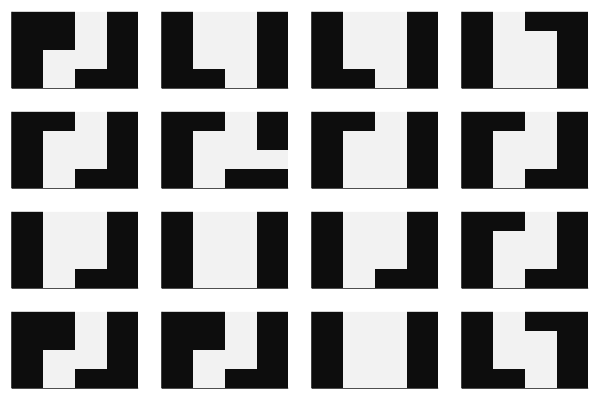

In [2]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [3]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 1
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 181


Number of parameters in generator: 31


[3.1477644466876016, 4.020819120138586, 3.798506535238645, 0.1893715872327701, 5.920898731607372, 1.4205145760780549, 3.1787975583856247, 5.808301521160205, 2.2960296056577745, 4.018396668153195, 5.958606625175371, 3.1518521887167963, 2.2419253397569787, 3.2793725041641, 0.6893295363152603, 1.8841886928917573, 5.821880575701356, 3.9372115662216705, 0.5265433870254368, 0.21922619344349042, 3.20312690850394, 1.4564025225167714, 2.2610639022592864, 1.6830819631262217, 2.6883623214428263, 6.274022169073237, 0.815727894008209, 2.0961104472611347, 3.774992652923352, 5.427148343776827, 3.551983132304993]


μ: 6.5
σ: 0.9660917830792959


Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

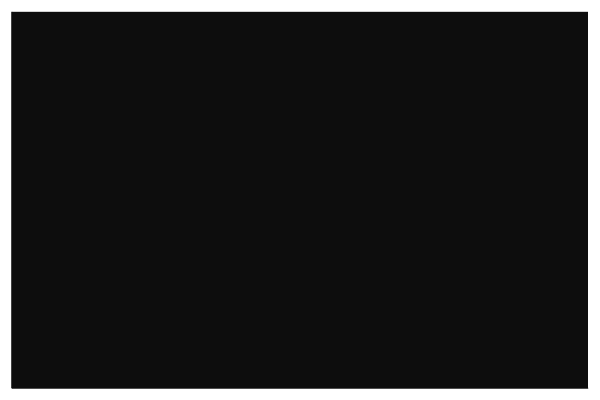

In [4]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [5]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 5000
dispatch!(g, rand(nparams).*2π)
function run_g(theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N || typeof(samples) != Matrix{Int64} #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    -mean(log.(run_d_fake(run_g(theta, nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

0.6173626f0

In [6]:
# using Plots
# using Statistics

# p = []
# for _ in 1:500
#     push!(p, gLoss())
# end

# histogram(p, bins=20, xlabel="gLoss", ylabel="Frequency")

# #@time gLoss() #It's still decently spread out...

In [7]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [8]:
g_lr = 1
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
g_epochs = 4
d_epochs = 2
epochs = 10

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        dispatch!(-, g, parametershift_grad() * g_lr)
        push!(gLoss_values, gLoss())
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch_size
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            z = pprior()
            push!(fake, convertgd(z |> g |> measure))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch_size)
    end
    println("iteration $i done in: ", time() - t)
end

In [ ]:
println("Generator loss")

for l in gLoss_values
    println(l)
end

plot(gLoss_values, title = "Generator Loss", linewidth=3)

In [ ]:
println("Discriminator loss")

for l in dLoss_values
    println(l)
end

plot(dLoss_values, title = "Discriminator Loss", linewidth=3)

In [ ]:
#Testing the Discriminator

d_fake = run_d_fake(run_g((pprior())))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = run_d_real(run_g((data_train[index])))
println("real data: $d_real") #Should print a number close to 1

In [ ]:
#Testing the Generator

# nsamples = 4
# samples = run_g(nsamples)
# plot([heatmap(rotl90(reshape(s, compress_size, compress_size)), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Not sure if the reshaping is correct but whatever